In [8]:
# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time

# import Koopman Libraries
from core.koopman_core_linear import KoopDNN_linear, KoopmanNet_linear, KoopmanNetCtrl_linear
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift

# Import Adaptive Koopman
from core.adapt_net_linear import AdaptNet_linear
import scipy.io

In [9]:
# quad pars
quad_pars = {}
quad_pars['m'] = 2.0
quad_pars['l'] = 0.2
quad_pars['I'] = 1.0

# quad parameters changed
quad_pars_changed = {}
quad_pars_changed ['m'] = 1.0 #0.1
quad_pars_changed ['l'] = 1 # 2
quad_pars_changed ['I'] = 1.0#

quad_pars_changed ['ext_torque'] = False
SNR_DB = 10
quad_pars_changed ['ext_torque_type'] = 'gaussian' # constant, sinosoidal, gaussian, 'random'
quad_pars_changed ['SN'] = (10**(SNR_DB/10))

In [10]:
def quad_dynamics(dt, x, T, pars):
    """
    dt = timestep
    x = [y, z, theta, y_d, z_d, theta_d];
    F = Force Input
    pars = system parameters
    """

    m = pars['m']  # mass of the drone
    l = pars['l']  # length of the drone arm
    I = pars['I']  # Inertia (I_xx) for the drone

    g = 9.81 

    ## dynamics of the system

    y_ddot = (-1/m)*np.sin(x[2])*(T[0] + T[1])
    z_ddot = -g + (1/m)*np.cos(x[2])*(T[0] + T[1])
    th_ddot = (l/I)*(-T[0] + T[1])

    y_d = y_ddot*dt + x[0]
    z_d = z_ddot*dt + x[1]
    th_d = th_ddot*dt + x[2]

    y = (1/2)*y_ddot*(dt**2) + x[0]*dt + x[3]
    z = (1/2)*z_ddot*(dt**2) + x[1]*dt + x[4]
    th = (1/2)*th_ddot*(dt**2) + x[2]*dt + x[5]

    return np.array([y,z,th,y_d,z_d,th_d])

def quad_inverse_dyn(x,x_ddot, pars):
    m = pars['m']  # mass of the drone
    l = pars['l']  # length of the drone arm
    I = pars['I']  # Inertia (I_xx) for the drone

    g = np.array([0, -9.81, 0])
    M = np.array([[(-1/m)*np.sin(x[2]), (-1/m)*np.sin(x[2])],
                  [(1/m)*np.cos(x[2]), (1/m)*np.cos(x[2])],
                  [(-l/I), (l/I)]]);

    T = np.matmul(np.linalg.pinv(M), (x_ddot-g).reshape(-1,1))

    return T.reshape(-1,)

    
    

    

In [11]:
from dynamics.path_generator import cubic_spline_interpolation

In [20]:
num_states = 3
dt = 0.01
num_snaps = 100
num_wp = 10

# generate path
t_end = dt*num_snaps; 
t_wp = np.zeros((num_wp,))
q_wp = np.zeros((num_states, num_wp))
for s in range(num_wp):
    if s == 0:
        q_wp[0,0] = 2*np.random.rand(1,) - 1
        q_wp[1,0] = (np.pi/2)*(2*np.random.rand(1,) - 1)
        q_wp[2,0] = 0.1*(2*np.random.rand(1,) - 1)
        t_wp[s] = 0;
        q_wp_dot = 0.05*(2*np.random.rand(num_states,) - 1);
    else:
        t_wp[s] = s*t_end/num_wp;
        q_wp[:,s] = q_wp[:,s-1] + q_wp_dot*(t_wp[s]-t_wp[s-1]);
        q_wp_dot[0:2] = 0.05*(2*np.random.rand(2,) - 1);
        q_wp_dot[2] = 0.05*(2*np.random.rand(1,) - 1);


q_traj, qd_traj, qddot_traj = cubic_spline_interpolation(np.transpose(q_wp),t_end,num_snaps-1);

In [ ]:
def controller_PD(gains, q_des, qd_des, )

In [25]:
num_inputs = 2
X = np.zeros((num_snaps, 2*num_states))
F= np.zeros((num_snaps-1, num_inputs))

pars = quad_pars

X[0,:num_states] = q_traj[:,0];
X[0,num_states:] = qd_traj[:,0];


Kp = 16;
Kv = 8;
F_dash = np.zeros((num_states,num_snaps))
for j in range(num_snaps-1):
    F[j,:] =  Kv*(qd_traj[:,j] - X[j,num_states:]) + Kp*(q_traj[:,j] - X[j,:num_states])

    X[j+1,:] = quad_dynamics(dt, X[j,:], F[j,:], pars);
    

ValueError: could not broadcast input array from shape (3,) into shape (2,)

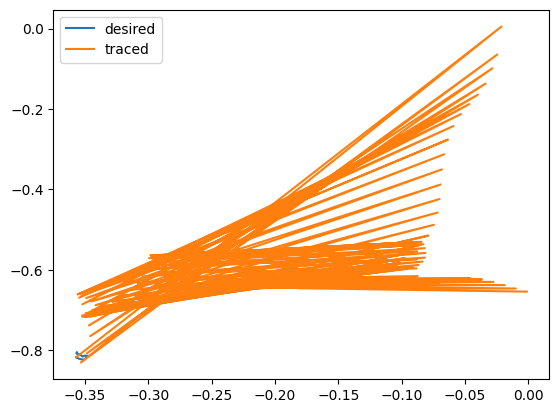

In [24]:
plt.plot(q_traj[0,:], q_traj[1,:], label= 'desired')
plt.plot(X[:,0], X[:,1], label = 'traced')
plt.legend()